# CONTEXTO DO PROBLEMA

A **Insurance All** é uma empresa que fornece seguro de saúde para seus clientes e o time de produtos está analisando a possibilidade de oferecer aos assegurados, um novo produto: Um seguro de automóveis.

Assim como o seguro de saúde, os clientes desse novo plano de seguro de automóveis precisam pagar um valor anualmente à Insurance All para obter um valor assegurado pela empresa, destinado aos custos de um eventual acidente ou dano ao veículo.

A Insurance All fez uma pesquisa com cerca de 380 mil clientes sobre o interesse em aderir a um novo produto de seguro de automóveis, no ano passado. Todos os clientes demonstraram interesse ou não em adquirir o seguro de automóvel e essas respostas ficaram salvas em um banco de dados junto com outros atributos dos clientes.

O time de produtos selecionou 127 mil novos clientes que não responderam a pesquisa para participar de uma campanha, no qual receberão a oferta do novo produto de seguro de automóveis. A oferta será feita pelo time de vendas através de ligações telefônicas.

Contudo, o time de vendas tem uma capacidade de realizar 20 mil ligações dentro do período da campanha.

# O PROBLEMA

Nesse contexto, você foi contratado como um consultor de Ciência de Dados para construir um modelo que prediz se o cliente estaria ou não interessado no seguro de automóvel. 

Com a sua solução, o time de vendas espera conseguir priorizar as pessoas com maior interesse no novo produto e assim, otimizar a campanha realizando apenas contatos aos clientes mais propensos a realizar a compra.


Como resultado da sua consultoria, você precisará entregar um relatório contendo algumas análises e respostas às seguintes perguntas:

**1.** Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

**2.** Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

**3.** E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

**4.** Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

# ENTENDIMENTO DO PROBLEMA

**Motivação:**
   - A empresa vai realizar uma campanha para um novo produto (seguro de automóvel).


**Causa Raiz do Problema:**
   - Identificar clientes com maior interesse no seguro do automóvel.


**Dados para Resolver o Problema:**
   - Os dados estão armazenados em um banco de dados PostgresSQL na AWS.
    

**Fomato da Solução:**

   - **Granularidade:** Previsão da probabilidade de compra por cliente.
   - **Tipo de Problema:** Previsão da probabilidade de compra.
   - **Potênciais Métodos:** Ranqueamento, Classificação.
   - **Formato da Entrega:** NÃO DEFINIDO

# 0.0 IMPORTS

In [59]:
# Colect and manipulation
import psycopg2              as pg
import pandas                as pd

# Visualization
import matplotlib.pyplot     as plt
import seaborn               as sns

# Statistic and math
from scipy                   import stats
import numpy                 as np

# Data preparation
from sklearn.preprocessing   import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

# ML
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.naive_bayes     import GaussianNB
import xgboost               as xgb
import random

# Metrics and performance
from scikitplot              import metrics
from sklearn.model_selection import StratifiedKFold
from skopt                   import BayesSearchCV
from sklearn.metrics         import roc_auc_score

# others
import warnings
from typing                  import Iterable, Any
from itertools               import product
import pickle

## 0.1 Funções Auxiliares

In [60]:
# ignore warnings
warnings.filterwarnings('ignore')

# correlation categories
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) **2 / (n-1)
    rcorr = r - (r-1) **2 / (n-1)
    
    return np.sqrt((chi2_corr / n) / (min(kcorr-1, rcorr-1)))


# Show matrix correlation
def show_matrix(col, data, output='list'):

    rows = []
    index = []
    columns = []

    for c in data.columns:

        result = cramer_v(x=data[str(col)], y=data[str(c)])

        rows.append(result)
        index.append(str(c))
        columns.append(str(col))
        
    if output == 'list':
        return rows
    
    elif output == 'dict':
        return pd.DataFrame(rows, index=index, columns=[str(col)])
    
    
def precision_at_k(data, k=20000):
    
    '''
    A função recebe os dados e o numero de Top K linhas
    e retorna  o resultado da métrica precision @k.
    '''
    
    # Sort clients by propensity score
    data = data.sort_values(by='score', ascending=False)

    # Reset index
    data = data.reset_index(drop=True)

    # Create ranking order
    data['ranking'] = data.index + 1

    # Calculate precision in K
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k'] # Return result precision


def recall_at_k(data, k=20000):
    
    '''
    A função recebe os dados e o numero de Top K linhas
    e retorna  o resultado da métrica recall @k.
    '''

    # Reset index
    data = data.reset_index(drop=True)

    # Create ranking order
    data['ranking']  = data.index + 1

    # Calculate recall in K
    data['recall_at_k']= data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k'] # Return result recall at k


def cross_validation(model_name, x, y, model, cv, topk=20000, verbose=True):
    
    '''
    A função recebe o nome do modelo, modelo, dados,
    numero de folds e o numero de pessoas da base ordenada e retorna um
    dataframe com as métricas precision e recall para o topk escolhido.
    
    model_name=nome do modelo, x=features, y=target, model=modelo instanciado,
    cv=folds, top5=pessoas da base ordenada
    '''
    
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    precision = []
    recall = []
    roc_auc = []
    k = 0
    
    for train, test in kfold.split(x, y):
    
        k += 1
        
        if verbose:
            print(f'Number KFold: {k}/{cv}')

        # -- Split data train
        x_train_not_id = x.iloc[train].drop(columns=['id']).copy() 
        x_train = x_train_not_id.copy() # y to train
        y_train = y.iloc[train]  # x to train
        
        # -- Split data test
        x_test_not_id = x.iloc[test].drop(columns=['id']).copy()
        x_val = x_test_not_id.copy() # x to test
        y_val = y.iloc[test]  # y to test
        
        #  x to compute metric with ID
        x_val_id = x.iloc[test]

        # Model training
        model_trained = model.fit(x_train_not_id, y_train)
        yhat_model = model_trained.predict_proba(x_test_not_id)

        # -- Performance
        x_val_id['response'] = y_val.copy() # Add target in the data to cumpute metric

        # Propensity score
        x_val_id['score'] = list(yhat_model[:, 1]).copy()
        
        df8 = x_val_id.copy()

        # Sort clients by propensity score
        df8 = df8.sort_values(by='score', ascending=False)

        # Compute precision at K
        precision.append(precision_at_k(df8))
        recall.append(recall_at_k(df8))
        roc_auc.append(roc_auc_score(y_val, yhat_model[:, 1]))
        
        
    model_metric = pd.DataFrame({
            'model_name': model_name,
            f'precision_top_{topk}': np.mean(precision),
            f'recall_top_{topk}': np.mean(recall),
            'ROC AUC': np.mean(roc_auc)
            }, index=[0])
    
    return model_metric


def grid_parameters(parameters: dict[str, Iterable[Any]]) -> Iterable[dict[str, Any]]:
    
    '''
    A função recebe o conjunto de parametros e itera
    entre as possibilidades de junções de cada um
    '''
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))

## 0.2 Coleta de Dados

In [61]:
# Creadentials
HOST     = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
PORT     ='5432'
USER     ='member'
DATABASE ='comunidadedsdb'
PASSWORD = 'cdspa'


try: # Connect DB
    conn = pg.connect(
        host=HOST,port=PORT, database=DATABASE, user=USER, password=PASSWORD
    )
    
    # Query data
    query = """
        SELECT *
        FROM pa004.users u LEFT JOIN pa004.vehicle v on (u.id = v.id)
                           LEFT JOIN pa004.insurance i on (u.id = i.id)  
    """
    
    # Read in sql and parse to Dataframe
    df = pd.read_sql(query, conn)
    df = df.drop(df.columns[[5]], axis=1)
    df['id'] = list(df.index)
    conn.close()
    
except Exception as e: # Connection Error  
    print("Database connection failed due to {}".format(e))
    
df.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,id
0,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0,0
1,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0,1
2,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0,2
3,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0,3
4,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0,4


# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [62]:
# Copy data
df1 = df.copy()

print(f'Nº Rows: {df1.shape[0]}')
print(f'Nº Columns: {df1.shape[1]}')

Nº Rows: 381109
Nº Columns: 12


## 1.2 Tipo de Dados

In [63]:
df1.dtypes

gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
id                        int64
dtype: object

## 1.3 Verificação de Dados Faltantes

In [64]:
df1.isna().sum()

gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
id                      0
dtype: int64

## 1.4 Mudança de Tipo nos Dados

In [65]:
# vehicle demage - str to int
df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0).astype('int64')

## 1.5 Estatistica Descritiva

### 1.5.1 Atributos Numéricos

In [66]:
# Select numerical data
numerical = df1.select_dtypes(include=['int64', 'float64'])

# Calculate kurtosis and skew
kurtosis = numerical.apply(lambda x: x.skew())
skew = numerical.apply(lambda x: x.kurtosis())

# Describe data
describe = numerical.describe().T

# Add skew and kurtosis in describe
describe['skew'] = skew
describe['kurtosis'] = kurtosis

# Show describe
describe

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,-0.565655,6.725390e-01
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,-0.867857,-1.152664e-01
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,-0.970810,-9.000081e-01
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,464.354302,-2.159518e+01
vehicle_damage,381109.0,0.504877,0.499977,0.0,0.0,1.0,1.0,1.0,-1.999630,-1.950724e-02
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,-1.971871,1.677471e-01
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,34.004569,1.766087e+00
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,-1.200688,3.029517e-03
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,3.298788,2.301906e+00
id,381109.0,190554.000000,110016.836208,0.0,95277.0,190554.0,285831.0,381108.0,-1.200000,9.443274e-16


**Insight:**

<ins>Distribuição</ins>: Em geral, os dados não possuem erros ou inconsistências e, no total, os dados não parecem estar tão dispensos.

<ins>Negócio</ins>: Os clientes possuem idade média de 38 anos e há clientes na base entre 20 e 85 anos. 75% da base já possuiu previamente algum tipo de seguro com a Insurance All. Em média, os clientes pagaram 30K para obter cobertura de seguro e o valor máximo pago foi de  540K. Em média, há 112 formas de entrar em contato com os clientes e, em média, há clientes durante 154 dias e clientes mais recentes possuem 10 dias como clientes. E com a pesquisa feita pela empresa, 75% das pessoas informaram que não compraria o seguro de automóvel.

### 1.5.2 Atributos Categóricos

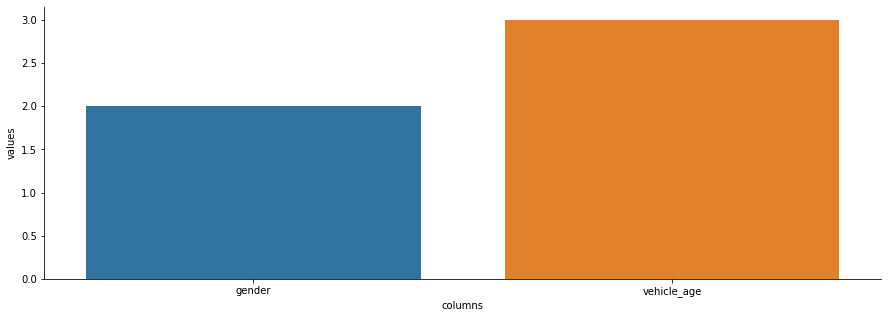

In [67]:
# Select categorical data
categorical = df1.select_dtypes(include=['object'])

# Count possible categorical values
unique_values = categorical.apply(lambda x: len(x.unique())).reset_index().rename(
    columns={'index': 'columns', 0: 'values'}).sort_values(by='values')

# Figure
plt.figure(figsize=(15, 5))
sns.barplot(x='columns', y='values', data=unique_values)
sns.despine(right=True)

**Insight:**

As variáveis categóricas possuem um range entre 2 e 3 dos possíveis valores.

# 2.0 FEATURE ENGINEERING

## 2.1 Mapa Mental de Hipóteses

<p align="center">
  <img src="../img/mind_map.PNG" width="1000" title="img-principal">
</p>

## 2.2 Lista de Hipóteses

### 2.2.1 Hipóteses Automóvel

**1.** Pessoas com automóveis quitados possuem interesse em contratar um seguro.

**2.** Pessoas com automóveis de trabalho não possuem interesse em contratar um seguro.

**3.** Pessoas com automóveis recém comprados possuem interesse em contratar um segeuro.

**4.** Pessoas com automóveis mais antigos não possuem interesse em contratar um seguro.

**5.** Pessoas com automóveis mais caros possuem interesse em contratar um seguro.

### 2.2.2 Hipóteses Valor

**1.** Pessoas não estão interessadas em contratar seguro com valoranual maior que 30K.

**2.** Pessoas estão interessas em contratar seguro com valor mensal menor que 2k.

**3.** Pessoas que investem mais em conservação do automóvel estão interessadas em contratar um seguro.

**4.** Pessoas que obtem um valor de cobertura do seguro acima de 100k estão interessados em contratar um seguro.

### 2.2.3 Hipóteses Cliente

**1.** Pessoas que já possuiram seu automóvel roubado, estão interessadas em contratar um seguro.

**2.** Pessoas que já tiveram seu carro batido, estão interessados em contratar um seguro.

**3.** Pessoas com idade maior que 30, estão interessadas em contratar um seguro.

**3.** Pessoas do sexo feminino são mais interessadas em contratar um seguro.

**4.** Pessoas que já tiveram aciendente grave, estão mais interessadas em contratar um seguro.

### 2.2.4 Hipóteses Região

**1.** Pessoas que estão localizadas em área de risco, estão mais interessadas em contratar um seguro.

**2.** Pessoas que deixam o automóvel em condomino, estão menos interessadas em contratar um seguro.

**3.** Pessoas que deixam o automóvel na rua, estão mais interessadas em contratar um seguro.

**4.** Pessoas que estão localizadas em áreas de grande circulação de veículos, possuem maior interesse em contratar um seguro.

## 2.3 Lista Final de Hipóteses

**1.** Pessoas com automóveis mais antigos não possuem interesse em contratar um seguro.

**2.** Pessoas não estão interessadas em contratar seguro com valor anual maior que 30K. 

**3.** Pessoas estão interessas em contratar seguro com valor mensal menor que 2k. 

**4.** Pessoas que investem mais em conservação do automóvel estão interessadas em contratar um seguro. 

**5.** Pessoas com idade maior que 30, estão interessadas em contratar um seguro. 

**6.** Pessoas do sexo feminino são mais interessadas em contratar um seguro. 

**7.** Pessoas que não possuem CNH, não estão mais interessadas em contratar um seguro.

**8.** Pessoas que já possuiram seguro em algum momento da vida, estão mais interessados em contratar o seguro da Insurance All.

**9.** Pessoas que são clientes a mais de 60 dias, estão mais interessadas em contratar um seguro.

## 2.4 Feature Engineering

In [68]:
# Copy dataframe
df2 = df1.copy()

# monthly_premium: Monthly amount paid
df2['monthly_premium'] = df2['annual_premium'].apply(lambda x: x / 12).round()

# age_category: over 30 years old or under and equal 30 years old.
df2['age_category'] = df2['age'].apply(lambda x: 'over_30_years' if x > 30 else 'between_30_years')

# vintage_category: between 60 day or more than 60 days.
df2['vintage_category'] = df2['vintage'].apply(lambda x: 'between_60_days' if x < 60 else 'more_60_days')

# 3.0 <s>FILTRAGEM DE DADOS<s>

## 3.1 <s>Filtragem de Linhas<s>

## 3.2 <s>Filtragem de Colunas<s>

# 4.0 EDA

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

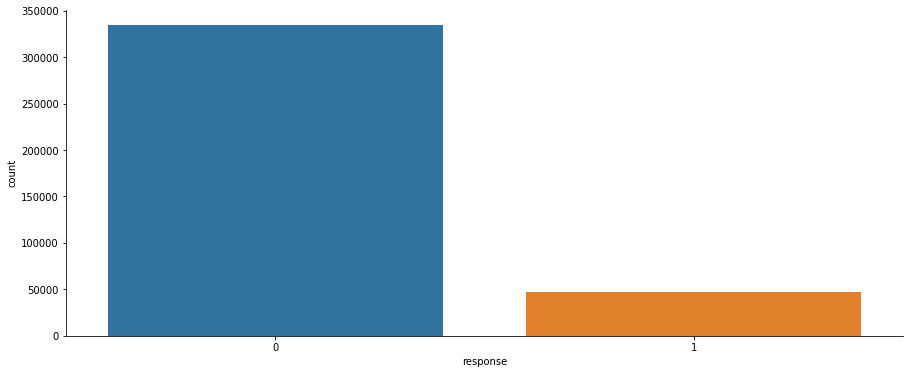

In [69]:
# Copy dataframe
df4 = df2.copy()

# Figure 
plt.figure(figsize=(15, 6))
sns.countplot(x='response', data=df4)
sns.despine(right=True);

**Insight:**

87% das pessoas informaram não estar interessadas em um seguro de automóvel e 12% informaram que estão. A distribuição dos dados na variável resposta estão desbalanceados.

### 4.1.2 Variável Numérica

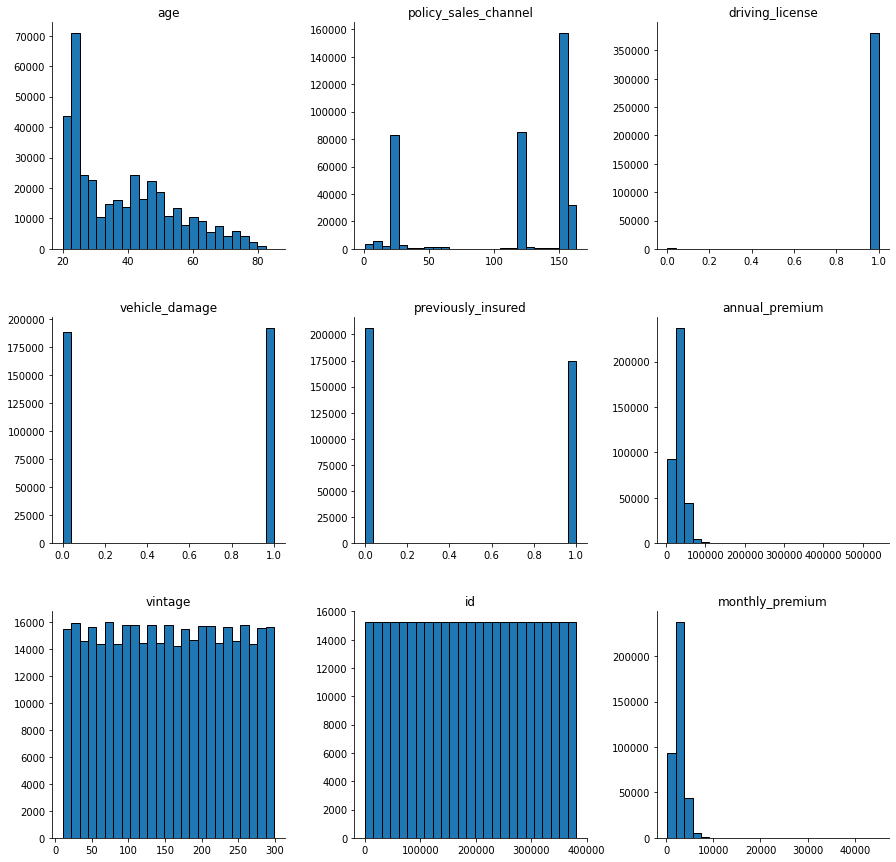

In [70]:
# Filter numerical data
numerical = df4.select_dtypes(include=['int64', 'float64']).drop(columns=['response', 'region_code'])

# Figure
numerical.hist(grid=False, bins=25, ec='k', figsize=(15, 15))
sns.despine(right=True);

**Insight:**


- age: Há um pico maior de pessoas com idades mais novas, na casa dos 20 anos. E há menor quantidade de pessoas com idade acima de 60 anos.


- policy_sales_channel: há maior quantidade de pessoas com cerca de 150 formas de contato.


- driving_license: Há maior quantidade de pessoas que possuem licença para dirigir.


- vehicle_damage: Os danos nos veículos estão bem distribuídos, posssuindo praticamente a mesma quantidade de pessoas que tem danos no veículo e que não tem.


- previously_insured: A maior parte das pessoas nunca foram clientes da empresa Insurance All.


- annual_premium: A maior parte das pessoas tem o preço do seguro anual em cerca de 50k.

### 4.1.3 Variável Categórica

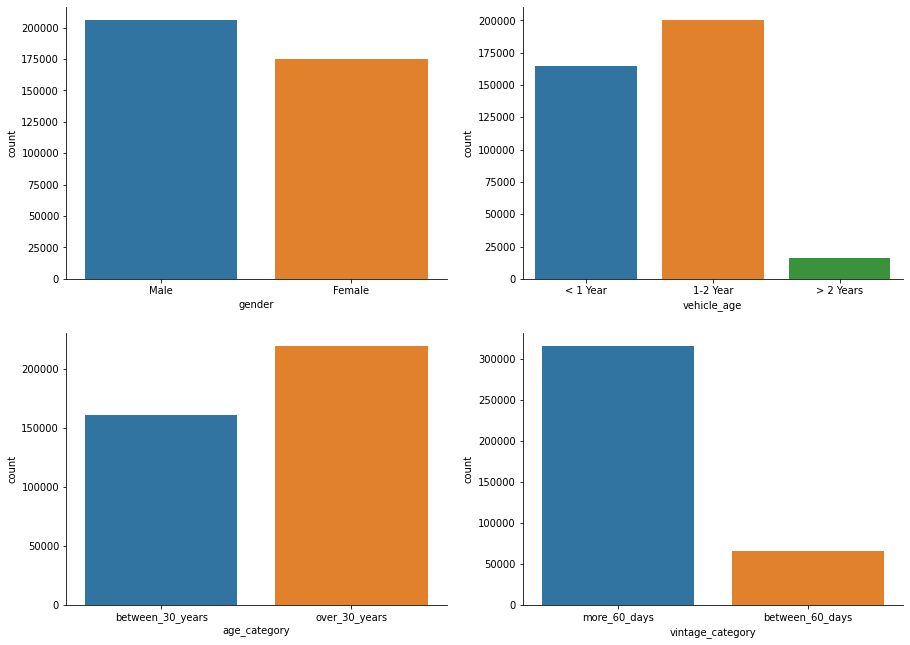

In [71]:
# Filter categorical data
categorical = df4.select_dtypes(include=['object'])

# Figure 1
plt.figure(figsize=(15, 11))
plt.subplot(2, 2, 1)
sns.countplot(x='gender', data=df4)

# Figure 2
plt.subplot(2, 2, 2)
sns.countplot(x='vehicle_age', data=df4)

# Figure 3
plt.subplot(2, 2, 3)
sns.countplot(x='age_category', data=df4)

# Figure 4
plt.subplot(2, 2, 4)
sns.countplot(x='vintage_category', data=df4)
sns.despine(right=True);

**Insight:**

- gender: A maior parte das pessoas são do sexo masculino.


- vehicle_age : A maior parte das pessoas possuem automóveis com idade entre 1 e 2 anos, e, a menor parte, possui idade maior que 2 anos.


- age_category: Na categoria de idade, há maior quantidade de pessoas acima dos 30 anos, devido ao range ser de 30 anos a 80 anos (valor maximo). E a categoria entre 30 anos possuir um range de 10 idades, apenas. 


- vintage_category: A maior parte das pessoas são clientes a mais de 60 dias.

## 4.2 Análise Bivariada

### H1. Pessoas com automóveis mais antigos não possuem interesse em contratar um seguro.

**VERDADEIRA** Pessoas com automóveis mais antigos NÃO possuem interesse em contratar um seguro.

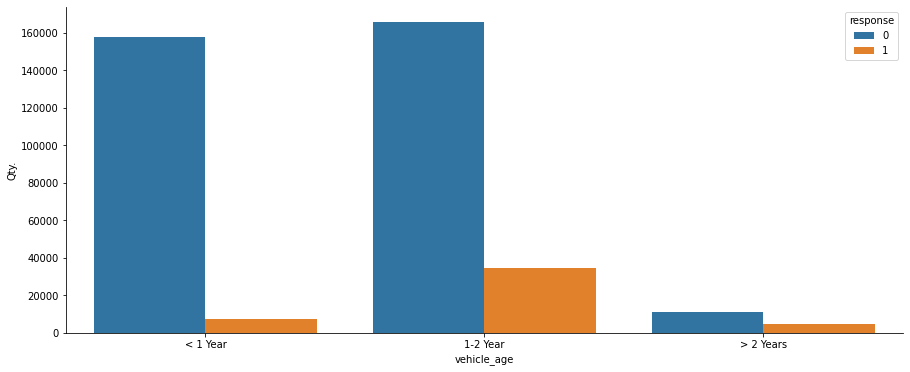

In [72]:
plt.figure(figsize=(15, 6))
sns.countplot(x='vehicle_age', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True)

### H2. Pessoas não estão interessadas em contratar seguro com valor anual maior que 30K. 

**FALSA** Pessoas estão interessadas em contratar seguro com valor anual MAIOR que 30K.  

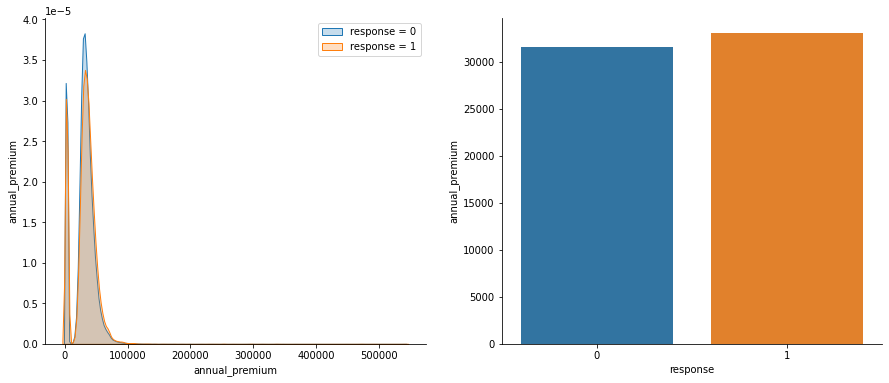

In [73]:
# -- Figure 1
not_interest = df4[df4['response'] == 0] # Filter response = 0
interest = df4[df4['response'] == 1] # Filter response = 1

# Create figure 1
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(x=not_interest['annual_premium'], label='response = 0', shade=True)
sns.kdeplot(x=interest['annual_premium'], label='response = 1', shade=True)
plt.legend()
plt.ylabel('annual_premium')

# -- Figure 2
aux1 = df4['annual_premium'].groupby(df4['response']).median().reset_index() # Group annual_premium by response

# Create Figure 2
plt.subplot(1, 2, 2)
sns.barplot(x='response', y='annual_premium', data=aux1)
sns.despine(right=True);

### H3. Pessoas estão interessas em contratar seguro com valor mensal menor que 2k.

**FALSA** Pessoas estão interessas em contratar seguro com valor mensal MAIOR que 2k.

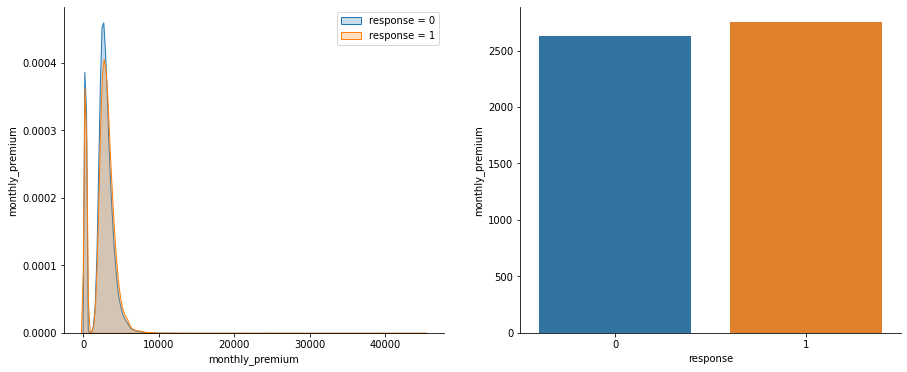

In [74]:
# -- Figure 1
not_interest = df4[df4['response'] == 0] # Filter response = 0
interest = df4[df4['response'] == 1] # Filter response = 1

# Create figure 1
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(x=not_interest['monthly_premium'], label='response = 0', shade=True)
sns.kdeplot(x=interest['monthly_premium'], label='response = 1', shade=True)
plt.legend()
plt.ylabel('monthly_premium')

# -- Figure 2
aux1 = df4['monthly_premium'].groupby(df4['response']).median().reset_index() # Group monthly_premium by response

# Create Figure 2
plt.subplot(1, 2, 2)
sns.barplot(x='response', y='monthly_premium', data=aux1)
sns.despine(right=True);

### H4. Pessoas que investem mais em conservação do automóvel estão interessadas em contratar um seguro.

**FALSA** Pessoas que possuem automóvel menos conservado (com dano), possuem maior interesse em contratar um seguro. 

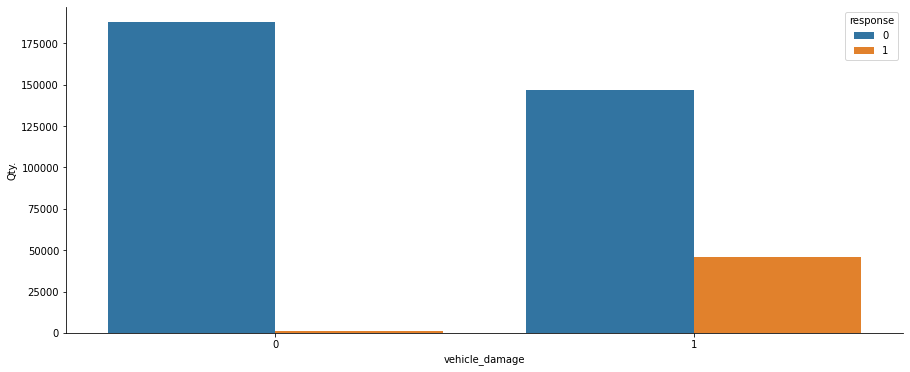

In [75]:
plt.figure(figsize=(15, 6))
sns.countplot(x='vehicle_damage', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

### H5. Pessoas com idade maior que 30, estão interessadas em contratar um seguro.

**VERDADEIRA** Pessoas com idade maior que 30 anos, estão mais interessadas em contratar um seguro do que pessoas com idade menor que 30.

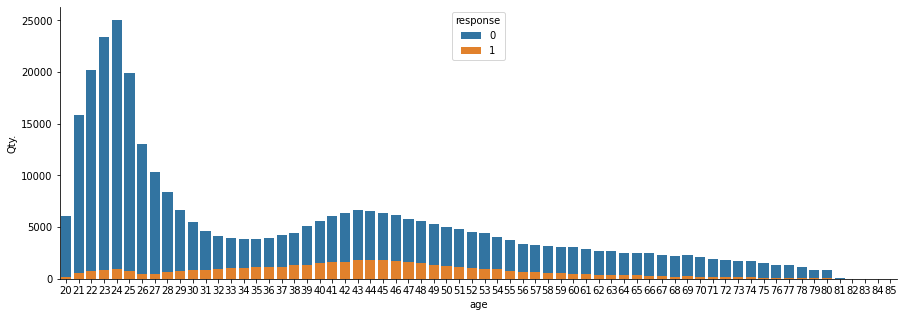

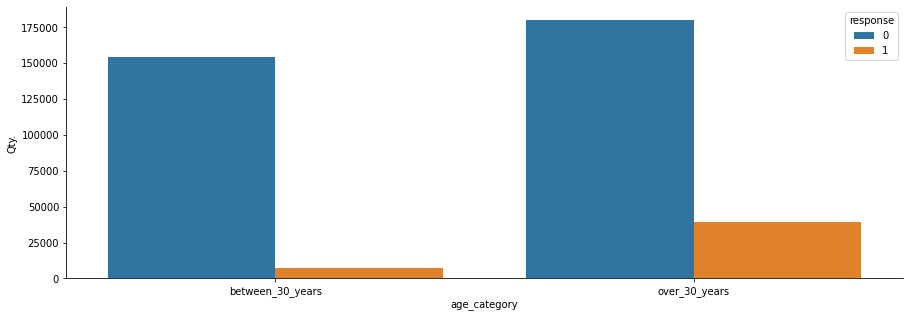

In [76]:
plt.figure(figsize=(15, 5))
sns.countplot(x='age', data=df4, hue='response', dodge=False)
plt.ylabel('Qty.')
sns.despine(right=True)

plt.figure(figsize=(15, 5))
sns.countplot(x='age_category', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

### H6. Pessoas do sexo feminino são mais interessadas em contratar um seguro.

**FALSA** Pessoas do sexo Masculino são mais interessdas do que o sexo Feminino em contratar um seguro.

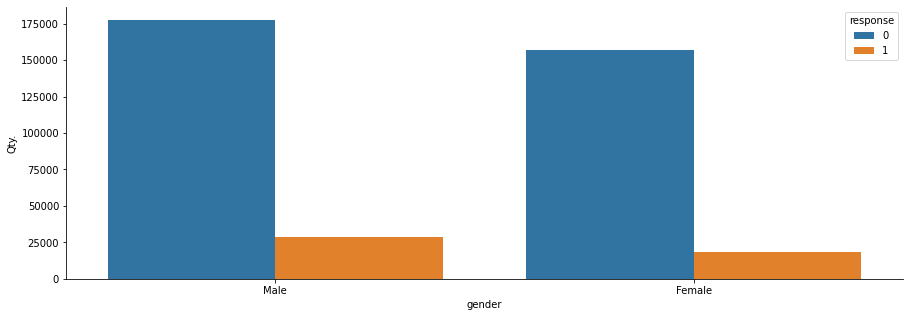

In [77]:
plt.figure(figsize=(15, 5))
sns.countplot(x='gender', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

### H7. Pessoas que não possuem licença para dirigir, estão menos interessadas em contratar um seguro.

**VERDADEIRA** Pessoas que não possuem licença para dirigir, estão menos interessadas em contratar um seguro.

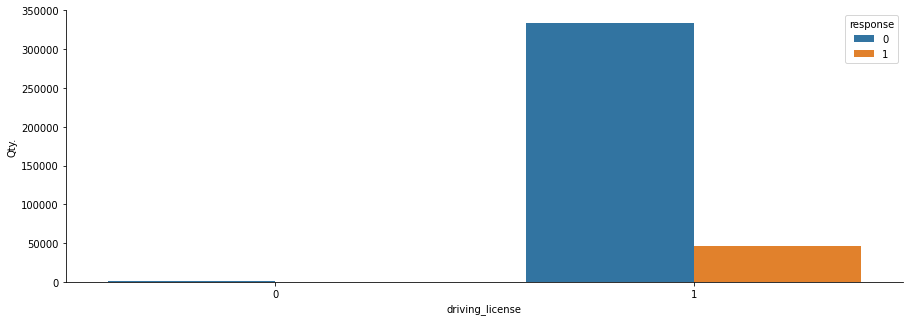

In [78]:
plt.figure(figsize=(15, 5))
sns.countplot(x='driving_license', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

### H8. Pessoas que já possuiram seguro em algum momento da vida, estão mais interessados em contratar o seguro da Insurance All.

**FALSA** Pessoas que NUNCA possuiram seguro em algum momento da vida, estão mais interessados em contratar o seguro da Insurance All.

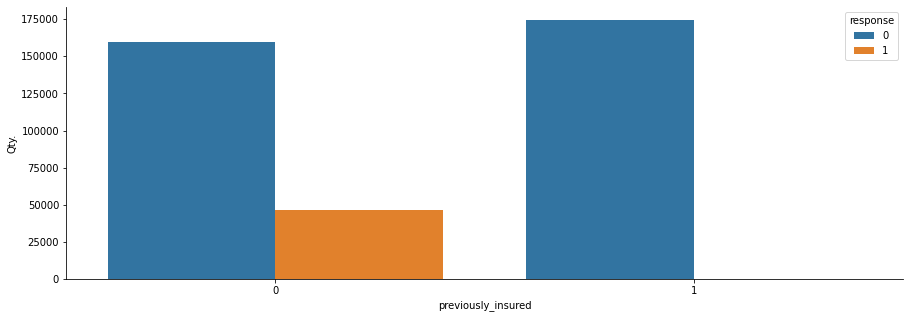

In [79]:
plt.figure(figsize=(15, 5))
sns.countplot(x='previously_insured', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

### H9. Pessoas que são clientes a mais de 60 dias, estão mais interessadas em contratar um seguro.

**VERDADEIRA** Pessoas que são clientes a mais de 60 dias, estão mais interessadas em contratar um seguro.

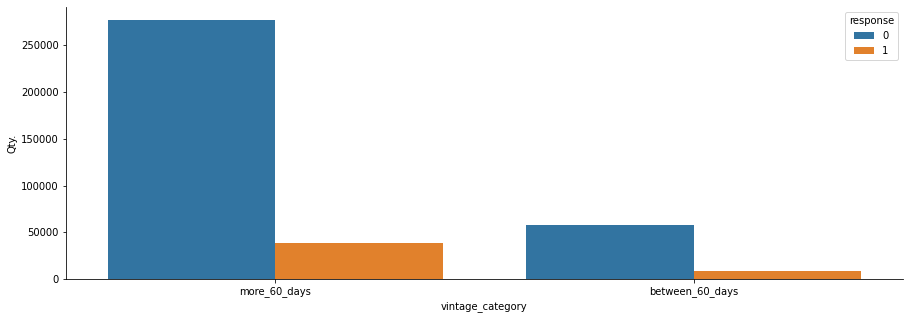

In [80]:
plt.figure(figsize=(15, 5))
sns.countplot(x='vintage_category', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

## 4.3 Análise Multivariada

### 4.3.1 Variável Numérica

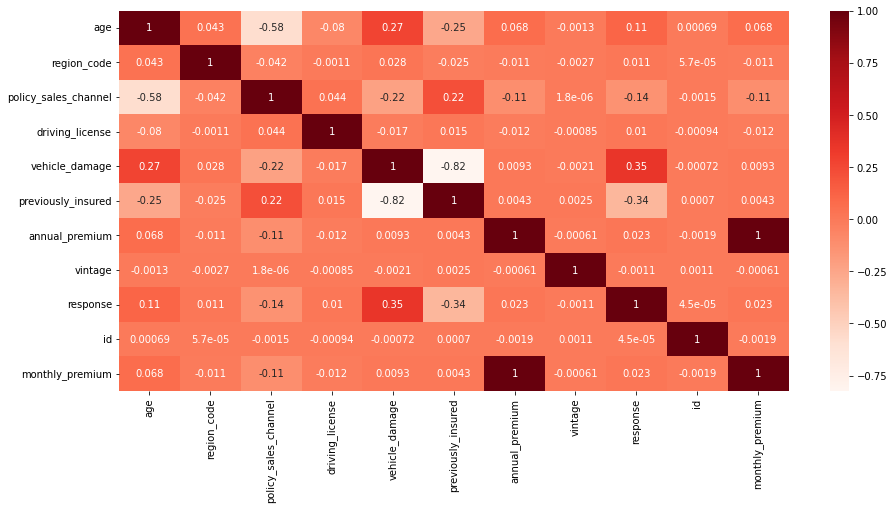

In [81]:
# Filter numerical data
numerical = df4.select_dtypes(include=['int64', 'float64'])

# Figure
plt.figure(figsize=(15, 7))
sns.heatmap(df4.corr(method='pearson'), annot=True, cmap='Reds');

**Insight:**

Nas variaveis numéricas, há correlação média entre o dano do automóvel e a idade do dono, também hpa com o dano do automóvel e se ele já possuiu seguro na vida. Além disso, há correlação média entre o cliente já possuir algum seguro na vida e a quantidade de canais de contato que a Insurance All possui dele(a).

Sobre a pessoas estar interessada no seguro, há correlação média entre o dano do veículo e o interesse por possuir o seguro.

### 4.3.2 Variável Categórica

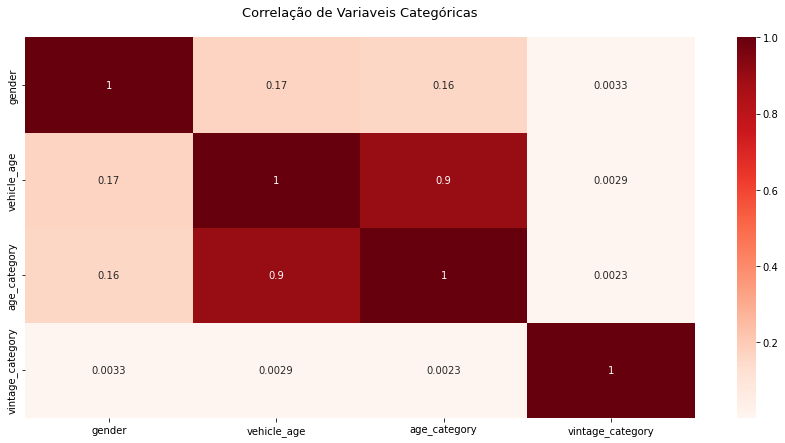

In [82]:
# Categorical data
categorical = df4.select_dtypes(include=['object'])

# Apply correlation categories
matrix = show_matrix(data=categorical, col='gender', output='dict')
data_columns = categorical.iloc[:, 1:]

for c in data_columns.columns:
    matrix[c] = show_matrix(data=categorical, col=c, output='list')

# Figure
plt.figure(figsize=(15, 7))
sns.heatmap(matrix, annot=True, cmap='Reds')
plt.title('Correlação de Variaveis Categóricas\n', fontsize=13);

**Insight:**

Nas variaveis categóricas, há pouca correlação para ser observada, a únca que chama atenção é uma correlação fraca entre a idade da pessoa com a idade do veículo.

# 5.0 PREPARAÇÃO DE DADOS

## 5.2 Standardization

In [83]:
df5 = df4.copy() # copy data

# StandardScaler method
sc_annual = StandardScaler()
sc_monthly = StandardScaler()

# annual_premium - Standardization
df5['annual_premium'] = sc_annual.fit_transform(df5[['annual_premium']].values)
pickle.dump(sc_annual, open('../src/preparation/annual_premium.pkl', 'wb')) # Save object to deploy

# monthly_premium - Standardization
df5['monthly_premium'] = sc_monthly.fit_transform(df5[['monthly_premium']].values)
pickle.dump(sc_monthly, open('../src/preparation/monthly_premium.pkl', 'wb')) # Sve object to deploy

## 5.3 Rescaling

In [84]:
# MinMaxScaler
ms_age = MinMaxScaler() 
ms_vintage = MinMaxScaler() 

# age - MinMaxScaler
df5['age'] = ms_age.fit_transform(df5[['age']].values)
pickle.dump(ms_age, open('../src/preparation/age.pkl', 'wb')) # Save object to deploy

# vintage - MinMaxScaler
df5['vintage'] = ms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(ms_vintage, open('../src/preparation/vintage.pkl', 'wb')) # Save object to deploy

## 5.4 Encoding

In [85]:
# gender - One Hot Encoding 
df5 = pd.get_dummies(df5, prefix='gender', columns=['gender'])

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# age_category - Label Encoding
df5['age_category'] = df5['age_category'].map({'between_30_years': 0, 'over_30_years': 1})

# vintage_category - Label Encoding
df5['vintage_category'] = df5['vintage_category'].map({'between_60_days': 0, 'more_60_days': 1})

# region_code - Target Encoding
target_encode_region = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region)
pickle.dump(target_encode_region, open('../src/preparation/region_code.pkl', 'wb')) # save object to deploy

# policy_sales_channel: Frequency Encoding
fe_policy_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_channel)
pickle.dump(fe_policy_channel, open('../src/preparation/policy_sales_channel.pkl', 'wb')) # save object to deploy

## 5.5 Divisão de Dados

### 5.5.1 Dados de Treino e Validação

In [37]:
# Filter features to train and test
x = df5.drop('response', axis=1)
y = df5['response']

# split data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20)

# merge data
df5 = pd.concat([x_train, y_train], axis=1)

### 5.5.2 Dados de Teste

In [38]:
# 20% sample to test
test_size = 0.20
n_sample = len(df5) * test_size

# Filter data test
data_test = df5.sample(round(n_sample))

# Remove sample from test data in training data
df5 = df5.drop(list(data_test.index))
x_train = df5.drop('response', axis=1).copy()
y_train = df5['response'].copy()

x_test = data_test.drop('response', axis=1) # X test
y_test = data_test['response']    # Y test

# 6.0 SELEÇÃO DE FEATURE

## 6.1 Feature Importance

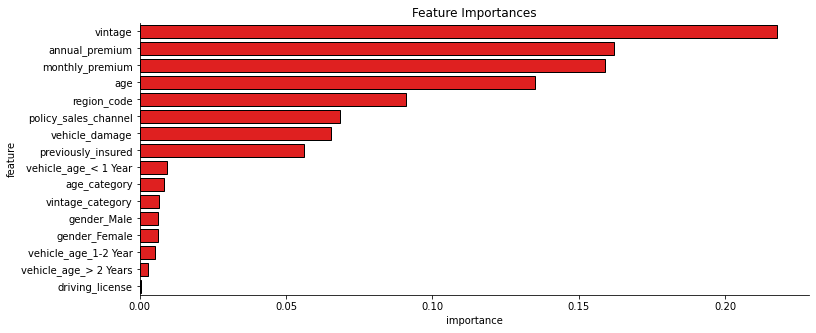

In [39]:
# Drop id column to model training
x_train_not_id = x_train.drop(columns=['id'])
x_val_not_id = x_val.drop(columns=['id'])

# Define Ranndom Forest
rf = RandomForestClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# Training random forest
training_rf = rf.fit(x_train_not_id, y_train)


# Feature importance
importances = training_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Create dataframe with feature and importance
df = pd.DataFrame()
for i, j in zip(x_train_not_id, training_rf.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df  = pd.concat([df, aux], axis=0)

# Create figure to show feature importance    
df = df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(12, 5))
sns.barplot(y='feature', x='importance', data=df, order=df['feature'], color='r', ec='k')
sns.despine(right=True)
plt.title('Feature Importances');

## 6.3 Features Selecionadas

In [40]:
cols_selected = ['vintage', 'annual_premium', 'monthly_premium', 'age', 'region_code',
                 'policy_sales_channel', 'vehicle_damage', 'previously_insured', 'id']

# Filter columns selected in data training and data validation and test
x_train = x_train[cols_selected]
x_val = x_val[cols_selected]
x_test = x_test[cols_selected]

#x_val2 = x_val2[cols_selected].copy() # Filter columns selected to metric
#x_val2['id'] = list(x_val2.index) # Create column ID with index 

# Show feature importance columns selected 
df.loc[df['feature'].isin(cols_selected)]

,feature,importance
0,vintage,0.217846
0,annual_premium,0.162116
0,monthly_premium,0.158839
0,age,0.135101
0,region_code,0.091117
0,policy_sales_channel,0.068354
0,vehicle_damage,0.065454
0,previously_insured,0.056283


# 7.0 MODELAGEM DE MACHINE LEARNING

## 7.1 KNN

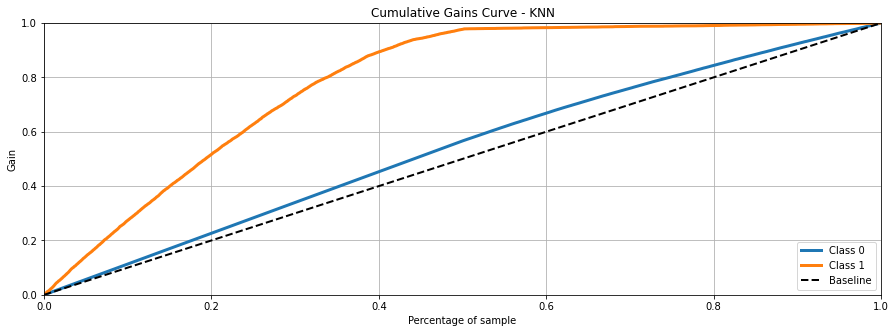

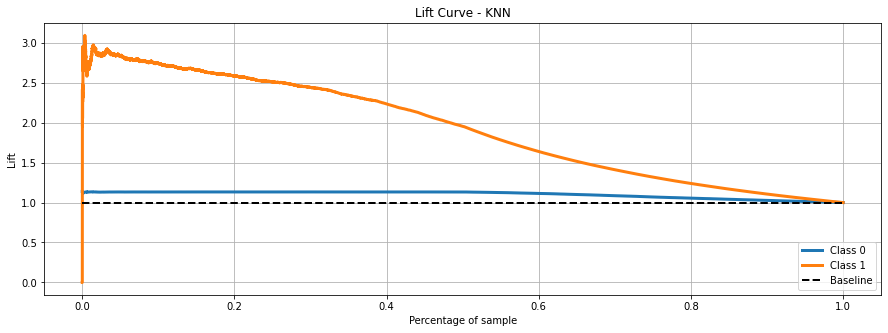

In [41]:
# Drop id column to model training
x_train_not_id = x_train.drop(columns=['id'])
x_val_not_id = x_val.drop(columns=['id'])

# Define KNN model
knn = KNeighborsClassifier(n_neighbors=20)

# KNN training
knn_trained = knn.fit(x_train_not_id, y_train)

# KNN prediction - Generalization
yhat_knn = knn_trained.predict_proba(x_val_not_id)

# Accumulative Gain - KNN
title1, title2 = 'Cumulative Gains Curve', 'Lift Curve'
metrics.plot_cumulative_gain(y_val, yhat_knn, figsize=(15, 5), title=title1+' - KNN');
metrics.plot_lift_curve(y_val, yhat_knn, figsize=(15, 5), title=title2+' - KNN');

### 7.1.1 KNN - Cross Validation

In [42]:
# Apply cross validation 
knn_cv = cross_validation(model_name='KNN', x=x_train, y=y_train, model=knn, cv=5, topk=20000)
knn_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,precision_top_20000,recall_top_20000,ROC AUC
0,KNN,0.270006,0.89893,0.825279


## 7.2 Logistic Regression

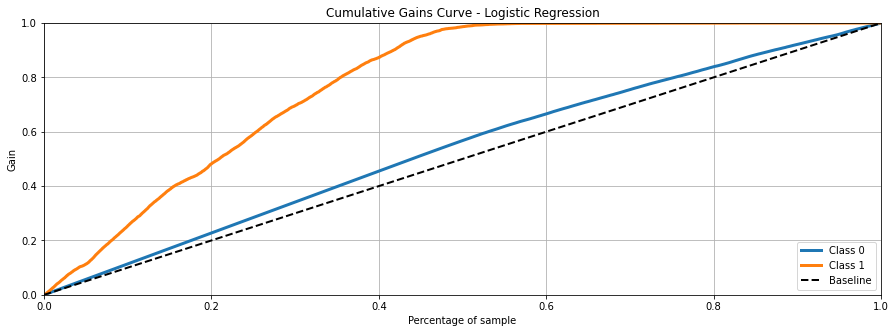

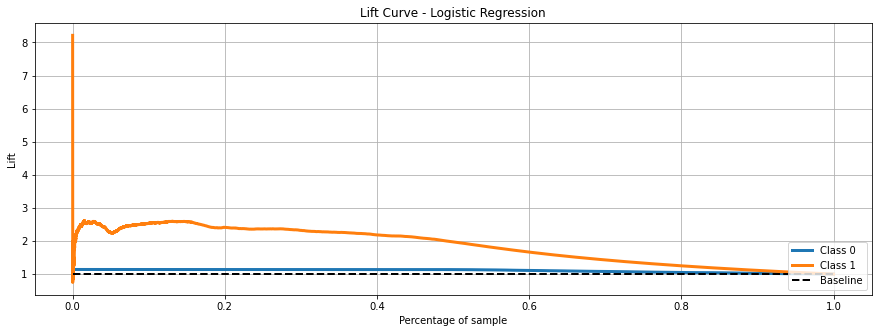

In [43]:
# Define Logistic Regression
lr = LogisticRegression()

# Logisitc Regression training
lr_trained = lr.fit(x_train_not_id, y_train)

# Logisitc Regression prediction - Generalization
yhat_lr = lr_trained.predict_proba(x_val_not_id)

# Accumularive Gain - Logistic Regression
metrics.plot_cumulative_gain(y_val, yhat_lr, figsize=(15, 5), title=title1+' - Logistic Regression')
metrics.plot_lift_curve(y_val, yhat_lr, figsize=(15, 5), title=title2+' - Logistic Regression');

### 7.2.1 Logistic Regression - Cross Validation

In [44]:
# Apply cross validation 
lr_cv = cross_validation(model_name='Logistic Regression', x=x_train, y=y_train, model=lr, cv=5, topk=20000)
lr_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,precision_top_20000,recall_top_20000,ROC AUC
0,Logistic Regression,0.265797,0.886358,0.816743


## 7.3 Random Forest

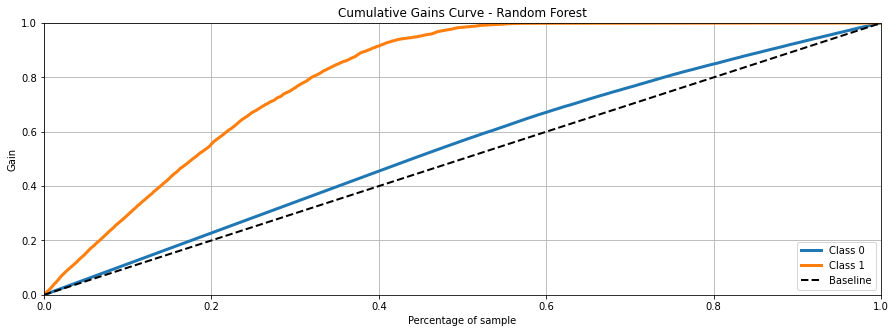

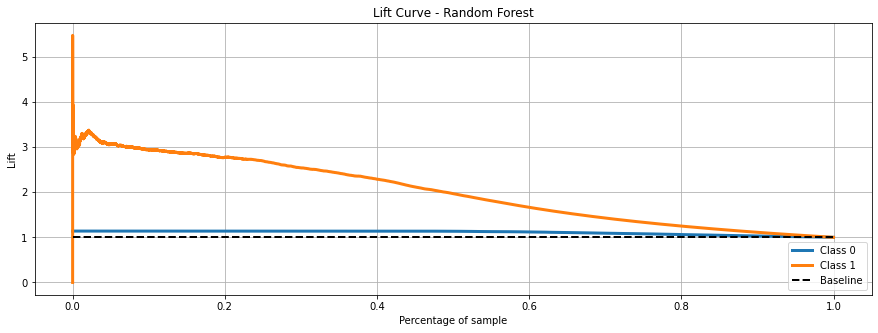

In [45]:
# Define Random Forest
rf = RandomForestClassifier(max_features='sqrt', n_estimators=10, max_depth=5)

# Rnadom Forest training
rf_trained = rf.fit(x_train_not_id, y_train)

# Random Forest prediction - Generalization
yhat_rf = rf_trained.predict_proba(x_val_not_id)

# Accuvalite gain - Random Forest
metrics.plot_cumulative_gain(y_val, yhat_rf, figsize=(15, 5), title=title1+' - Random Forest')
metrics.plot_lift_curve(y_val, yhat_rf, figsize=(15, 5), title=title2+' - Random Forest');

### 7.3.1 Random Forest - Cross Validation

In [46]:
# Apply cross validation 
rf_cv = cross_validation(model_name='Random Forest', x=x_train, y=y_train, model=rf, cv=5, topk=20000)
rf_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,precision_top_20000,recall_top_20000,ROC AUC
0,Random Forest,0.276086,0.920704,0.84253


## 7.4 XGBoost

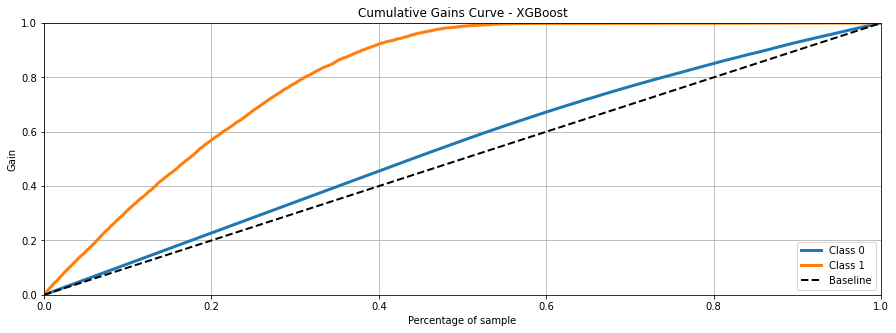

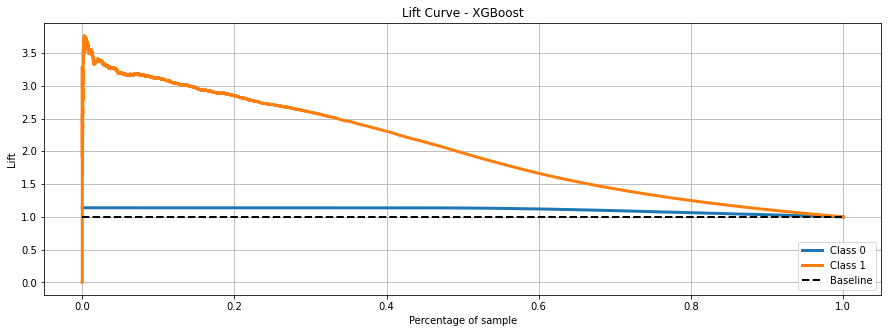

In [47]:
# Define XGB
xgb_model = xgb.XGBClassifier(max_features='sqrt', n_estimators=11, max_depth=7)

# XGB training
xgb_trained = xgb_model.fit(x_train_not_id, y_train)

# XGB prediction - Generalization
yhat_xgb = xgb_trained.predict_proba(x_val_not_id)

# Accumulative gain - XGB
metrics.plot_cumulative_gain(y_val, yhat_xgb, figsize=(15, 5), title=title1+' - XGBoost')
metrics.plot_lift_curve(y_val, yhat_xgb, figsize=(15, 5), title=title2+' - XGBoost');

### 7.4.1 XGBoost - Cross Validation

In [48]:
# Apply cross validation 
xgb_cv = cross_validation(model_name='XGBoost', x=x_train, y=y_train, model=xgb_model, cv=5, topk=20000)
xgb_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,precision_top_20000,recall_top_20000,ROC AUC
0,XGBoost,0.278796,0.929507,0.851243


## 7.5 Naive Bayes

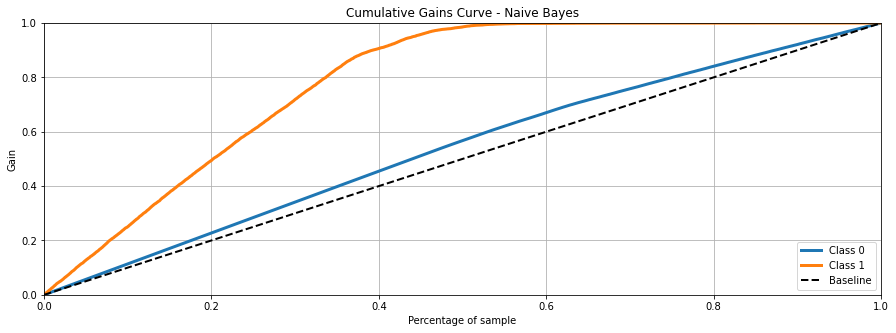

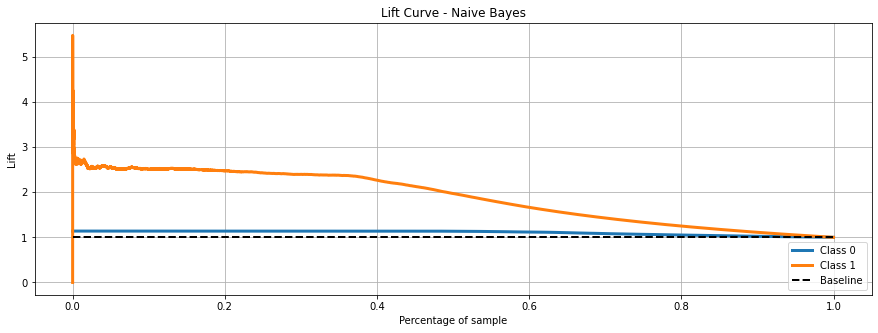

In [49]:
# Define model Decision Tree
bayes = GaussianNB()

# Tree training
bayes_trained = bayes.fit(x_train_not_id, y_train)

# Tree prediction - Generalization
yhat_bayes = bayes_trained.predict_proba(x_val_not_id)

# Accumulative gain - Tree
metrics.plot_cumulative_gain(y_val, yhat_bayes, figsize=(15, 5), title=title1+' - Naive Bayes')
metrics.plot_lift_curve(y_val, yhat_bayes, figsize=(15, 5), title=title2+' - Naive Bayes');

### 7.5.1 Naive Bayes - Cross Validation

In [50]:
# Apply cross validation 
bayes_cv = cross_validation(model_name='Naive Bayes', x=x_train, y=y_train, model=bayes, cv=5, topk=20000)
bayes_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,precision_top_20000,recall_top_20000,ROC AUC
0,Naive Bayes,0.272266,0.907933,0.824359


## 7.6 Comparação de Performance

### 7.6.1 Performance Real - Cross Validation 

In [51]:
pd.concat([knn_cv, lr_cv, rf_cv, xgb_cv, bayes_cv]).sort_values(by='recall_top_20000', ascending=False)

,model_name,precision_top_20000,recall_top_20000,ROC AUC
0,XGBoost,0.278796,0.929507,0.851243
0,Random Forest,0.276086,0.920704,0.842530
0,Naive Bayes,0.272266,0.907933,0.824359
0,KNN,0.270006,0.898930,0.825279
0,Logistic Regression,0.265797,0.886358,0.816743


# 8.0 AJUSTE DE HIPERPARAMETROS

## 8.1 Grid Search

In [52]:
parameters = {
    'max_features': ['sqrt', 'auto', 'log2'],
    'n_estimators': [7, 11, 15], 
    'max_depth': [5, 7, 9]
}

final_result, result_parameter = pd.DataFrame(), list()
for settings in grid_parameters(parameters):

    param = {
        'max_features': settings['max_features'], 'n_estimators': settings['n_estimators'], 'max_depth': settings['max_depth']
    }
 
    print(param)
    
    # model
    xgb_tunning = xgb.XGBClassifier(
        max_features=param['max_features'], n_estimators=param['n_estimators'], max_depth=param['max_depth']
    )
    
    # performance
    result = cross_validation(model_name='xgb_tunning', model=xgb_tunning, x=x_train, y=y_train, cv=5, topk=20000, verbose=False)
    final_result = pd.concat([final_result, result])
    result_parameter.append([param['max_features'], param['n_estimators'], param['max_depth']])

final_result['parameters'] = result_parameter
final_result.sort_values(by='precision_top_20000', ascending=False)

{'max_features': 'sqrt', 'n_estimators': 7, 'max_depth': 5}
{'max_features': 'sqrt', 'n_estimators': 7, 'max_depth': 7}
{'max_features': 'sqrt', 'n_estimators': 7, 'max_depth': 9}
{'max_features': 'sqrt', 'n_estimators': 11, 'max_depth': 5}
{'max_features': 'sqrt', 'n_estimators': 11, 'max_depth': 7}
{'max_features': 'sqrt', 'n_estimators': 11, 'max_depth': 9}
{'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 5}
{'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 7}
{'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9}
{'max_features': 'auto', 'n_estimators': 7, 'max_depth': 5}
{'max_features': 'auto', 'n_estimators': 7, 'max_depth': 7}
{'max_features': 'auto', 'n_estimators': 7, 'max_depth': 9}
{'max_features': 'auto', 'n_estimators': 11, 'max_depth': 5}
{'max_features': 'auto', 'n_estimators': 11, 'max_depth': 7}
{'max_features': 'auto', 'n_estimators': 11, 'max_depth': 9}
{'max_features': 'auto', 'n_estimators': 15, 'max_depth': 5}
{'max_features': 'auto', 'n_es

,model_name,precision_top_20000,recall_top_20000,ROC AUC,parameters
0,xgb_tunning,0.278816,0.929641,0.850694,"[log2, 7, 7]"
0,xgb_tunning,0.278816,0.929641,0.850694,"[sqrt, 7, 7]"
0,xgb_tunning,0.278816,0.929641,0.850694,"[auto, 7, 7]"
0,xgb_tunning,0.278796,0.929507,0.851243,"[auto, 11, 7]"
0,xgb_tunning,0.278796,0.929507,0.851243,"[log2, 11, 7]"
0,xgb_tunning,0.278796,0.929507,0.851243,"[sqrt, 11, 7]"
0,xgb_tunning,0.278636,0.929274,0.852043,"[sqrt, 15, 9]"
0,xgb_tunning,0.278636,0.929274,0.852043,"[auto, 15, 9]"
0,xgb_tunning,0.278636,0.929274,0.852043,"[log2, 15, 9]"
0,xgb_tunning,0.278536,0.928840,0.851488,"[log2, 15, 7]"


## 8.2 Modelo Final

### 8.2.1 Treinamento do Modelo

In [53]:
# Concat training data with validation data
training = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_val, y_val], axis=1)
df8 = pd.concat([training, validation], axis=0)

# Split features and target
x = df8.drop(columns=['response', 'id'])
y = df8['response']

# Add and remove id in X to compute metric
x_id = df8.drop(columns=['response'])
x_test_not_id = x_test.drop(columns=['id'])

# Define XGB
model_final = xgb.XGBClassifier(max_features='log2', n_estimators=11, max_depth=9)

# XGB final training
model_final_trained = model_final.fit(x, y)

### 8.2.2 Teste do Modelo

In [54]:
#test = pd.read_csv('data/test.csv')
#test_not_id = test.drop(columns=['id'])

Precision_topk_20000: 0.30843457827108645
Recall_topk_20000: 0.8289438323031443


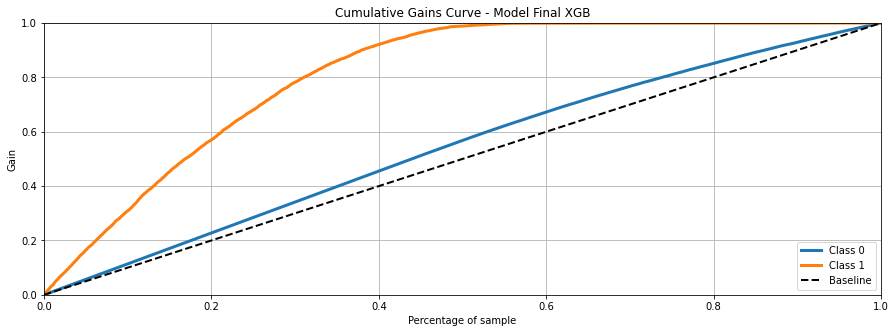

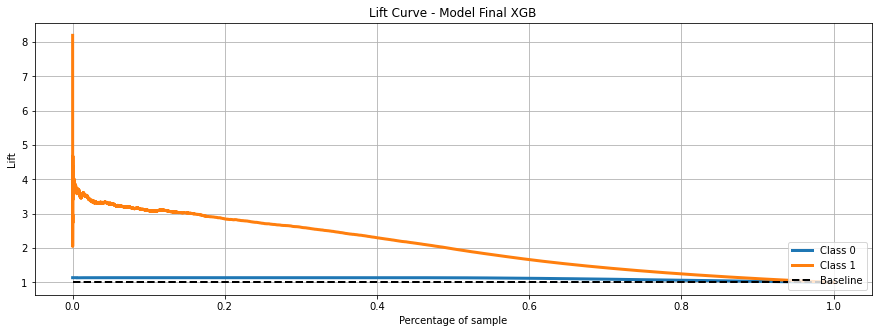

In [55]:
# Test data
#test = pd.read_csv('data/test.csv')
#test_not_id = test.drop(columns=['id'])

x_test_not_id = x_test.drop(columns=['id']).copy()

# Generalization - Predict
yhat_model_final = model_final_trained.predict_proba(x_test_not_id)

x_test['response'] = y_test.copy() # Add target in the data to cumpute metric

# Propensity score
x_test['score'] = list(yhat_model_final[:, 1]).copy() 
df8 = x_test.copy()

# Sort clients by propensity score
df8 = df8.sort_values(by='score', ascending=False)

# Compute precision at K
print('Precision_topk_20000:', precision_at_k(df8, k=20000))
print('Recall_topk_20000:', recall_at_k(df8, k=20000))

# Metrics Lift and Gain
metrics.plot_cumulative_gain(y_test, yhat_model_final, figsize=(15, 5), title=title1+' - Model Final XGB')
metrics.plot_lift_curve(y_test, yhat_model_final, figsize=(15, 5), title=title2+' - Model Final XGB');

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DOS RESULTADOS

### **1.** Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.


### **2.** Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?


### **3.** E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?


### **4.** Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?


# 10.0 DEPLOY DO MODELO EM PRODUÇÃO

## 10.1 Salvar Modelo Treinado

In [58]:
pickle.dump(model_final_trained, open('C:/Users/Jhonatans/projects/ML/Classification/Health-Insurance-Cross-Sell/src/model/xgboost.pkl', 'wb'))

## 10.2 Criando a Classe

In [97]:
import pickle
import numpy as np
import pandas as pd
import json

class CarInsurance:
    
    def __init__(self):
        
        self.path                 = 'C:/Users/Jhonatans/projects/ML/Classification/Health-Insurance-Cross-Sell/'
        self.annual_premium       = pickle.load(open(self.path + 'src/preparation/annual_premium.pkl', 'rb'))
        self.monthly_premium      = pickle.load(open(self.path + 'src/preparation/monthly_premium.pkl', 'rb'))
        self.policy_sales_channel = pickle.load(open(self.path + 'src/preparation/policy_sales_channel.pkl', 'rb'))
        self.age                  = pickle.load(open(self.path + 'src/preparation/age.pkl', 'rb'))
        self.region_code          = pickle.load(open(self.path + 'src/preparation/region_code.pkl', 'rb'))
        self.vintage              = pickle.load(open(self.path + 'src/preparation/vintage.pkl', 'rb'))
        
    def cleaning(self, df1):
        
        # vehicle demage - str to int
        df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0).astype('int64')
        
        return df1
        
    def feature_engineering(self, df2):
        
        # monthly_premium: Monthly amount paid
        df2['monthly_premium'] = df2['annual_premium'].apply(lambda x: x / 12).round()

        # age_category: over 30 years old or under and equal 30 years old.
        df2['age_category'] = df2['age'].apply(lambda x: 'over_30_years' if x > 30 else 'between_30_years')

        # vintage_category: between 60 day or more than 60 days.
        df2['vintage_category'] = df2['vintage'].apply(lambda x: 'between_60_days' if x < 60 else 'more_60_days')
        
        return 
    
    def preparation(self, df5):
        
        # -- Rescaling
        # annual_premium - Standardization
        df5['annual_premium'] = self.annual_premium.transform(df5[['annual_premium']].values)

        # monthly_premium - Standardization
        df5['monthly_premium'] = self.monthly_premium.transform(df5[['monthly_premium']].values)

        # -- MinMaxScaler
        # age - MinMaxScaler
        df5['age'] = self.age.transform(df5[['age']].values)

        # vintage - MinMaxScaler
        df5['vintage'] =self.vintage.transform(df5[['vintage']].values)
        

        ## -- Encoding
        # gender - One Hot Encoding 
        df5 = pd.get_dummies(df5, prefix='gender', columns=['gender'])

        # vehicle_age - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

        # age_category - Label Encoding
        df5['age_category'] = df5['age_category'].map({'between_30_years': 0, 'over_30_years': 1})

        # vintage_category - Label Encoding
        df5['vintage_category'] = df5['vintage_category'].map({'between_60_days': 0, 'more_60_days': 1})

        # region_code - Target Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map(self.region_code)

        # policy_sales_channel: Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.policy_sales_channel)
        
        
        # -- Feature Selection
        cols_selected = ['vintage', 'annual_premium', 'monthly_premium', 'age', 'region_code',
                         'policy_sales_channel', 'vehicle_damage', 'previously_insured']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data):

        # model prediction
        pred = model.predict_proba(test_data)
        
        # Join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.3 API Handler

In [100]:
import pickle
import pandas as pd
from flask import Flask, request, Response
#from src.class import CarInsurance

# loading model
path = 'C:/Users/Jhonatans/projects/ML/Classification/Health-Insurance-Cross-Sell/'
model = pickle.load(open(path + 'src/model/xgboost.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('/carInsurance/predict', methods=['POST'])
def carInsurance_predict():
    
    test_json = request.get_json()
    
    if test_json: # There is data
        if isinstance(test_json, dict): # unique exemple
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Class
        pipeline = CarInsurance()
        
        # data cleaning
        df1 = pipeline.cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ =='__main__':
    app.run('0.0.0.0', debug=True)